# Blockhouse Quant Task: Price Impact Analysis & Execution Strategy

**By: Aayush Kumar**
**Date: July 31, 2025**

---

### Introduction & Problem Statement
This notebook contains the complete analysis for the Blockhouse Work Trial Task. The project's goal is to model the temporary price impact from real order book data and formulate a rigorous mathematical framework for an optimal trade execution strategy.

In [6]:
# --- Part 1: Imports and Data Loading ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")

print("--- Libraries Imported Successfully ---")

# Load data into a dictionary of DataFrames
ticker_files = {
    "FROG": '/FROG_2025-05-02 00_00_00+00_00.csv',
    "CRWV": '/CRWV_2025-05-02 00_00_00+00_00.csv',
    "SOUN": '/SOUN_2025-05-02 00_00_00+00_00.csv'
}
dataframes = {}
print("\n--- Loading Data Files ---")
for ticker, filepath in ticker_files.items():
    try:
        dataframes[ticker] = pd.read_csv(filepath)
        print(f"Successfully loaded {ticker} data.")
    except FileNotFoundError:
        print(f"ERROR: File not found for {ticker} at path '{filepath}'. Please ensure it is uploaded.")

--- Libraries Imported Successfully ---

--- Loading Data Files ---
Successfully loaded FROG data.
Successfully loaded CRWV data.
Successfully loaded SOUN data.


In [7]:
# --- Helper Functions ---

def calculate_buy_impact(order_book_row, order_size_to_buy):
    """Calculates the true temporary price impact by 'walking the book'."""
    if order_size_to_buy == 0: return 0.0
    # Ensure the row has valid data before proceeding
    if pd.isna(order_book_row['ask_px_00']) or pd.isna(order_book_row['bid_px_00']):
        return np.nan
    mid_price = (order_book_row['ask_px_00'] + order_book_row['bid_px_00']) / 2
    if mid_price == 0: return np.nan

    remaining_size, total_cost = order_size_to_buy, 0.0
    for i in range(10):
        level_price = order_book_row[f'ask_px_{i:02d}']
        level_size = order_book_row[f'ask_sz_{i:02d}']
        if pd.isna(level_price) or pd.isna(level_size): break
        if remaining_size <= 0: break

        fill_size = min(remaining_size, level_size)
        total_cost += fill_size * level_price
        remaining_size -= fill_size

    if remaining_size > 0: return np.nan
    avg_execution_price = total_cost / order_size_to_buy
    slippage = avg_execution_price - mid_price
    return slippage

def sqrt_model(x, C):
    """Square-root model function: y = C * sqrt(x)"""
    return C * np.sqrt(x)

print("--- Helper functions defined successfully. ---")

--- Helper functions defined successfully. ---



--- Starting Analysis for FROG ---
Analysis complete for FROG.

--- Starting Analysis for CRWV ---
Analysis complete for CRWV.

--- Starting Analysis for SOUN ---
Analysis complete for SOUN.

--- Comparative Statistical Summary of Impact Parameter 'C' ---
             FROG        CRWV        SOUN
count  390.000000  390.000000  390.000000
mean     0.003730    0.004355    0.000412
std      0.006053    0.003004    0.000167
min      0.000385    0.000385    0.000385
25%      0.001727    0.002752    0.000385
50%      0.002360    0.003958    0.000385
75%      0.003560    0.005208    0.000385
max      0.082700    0.041684    0.003207

--- Generating Final Comparative Plots ---


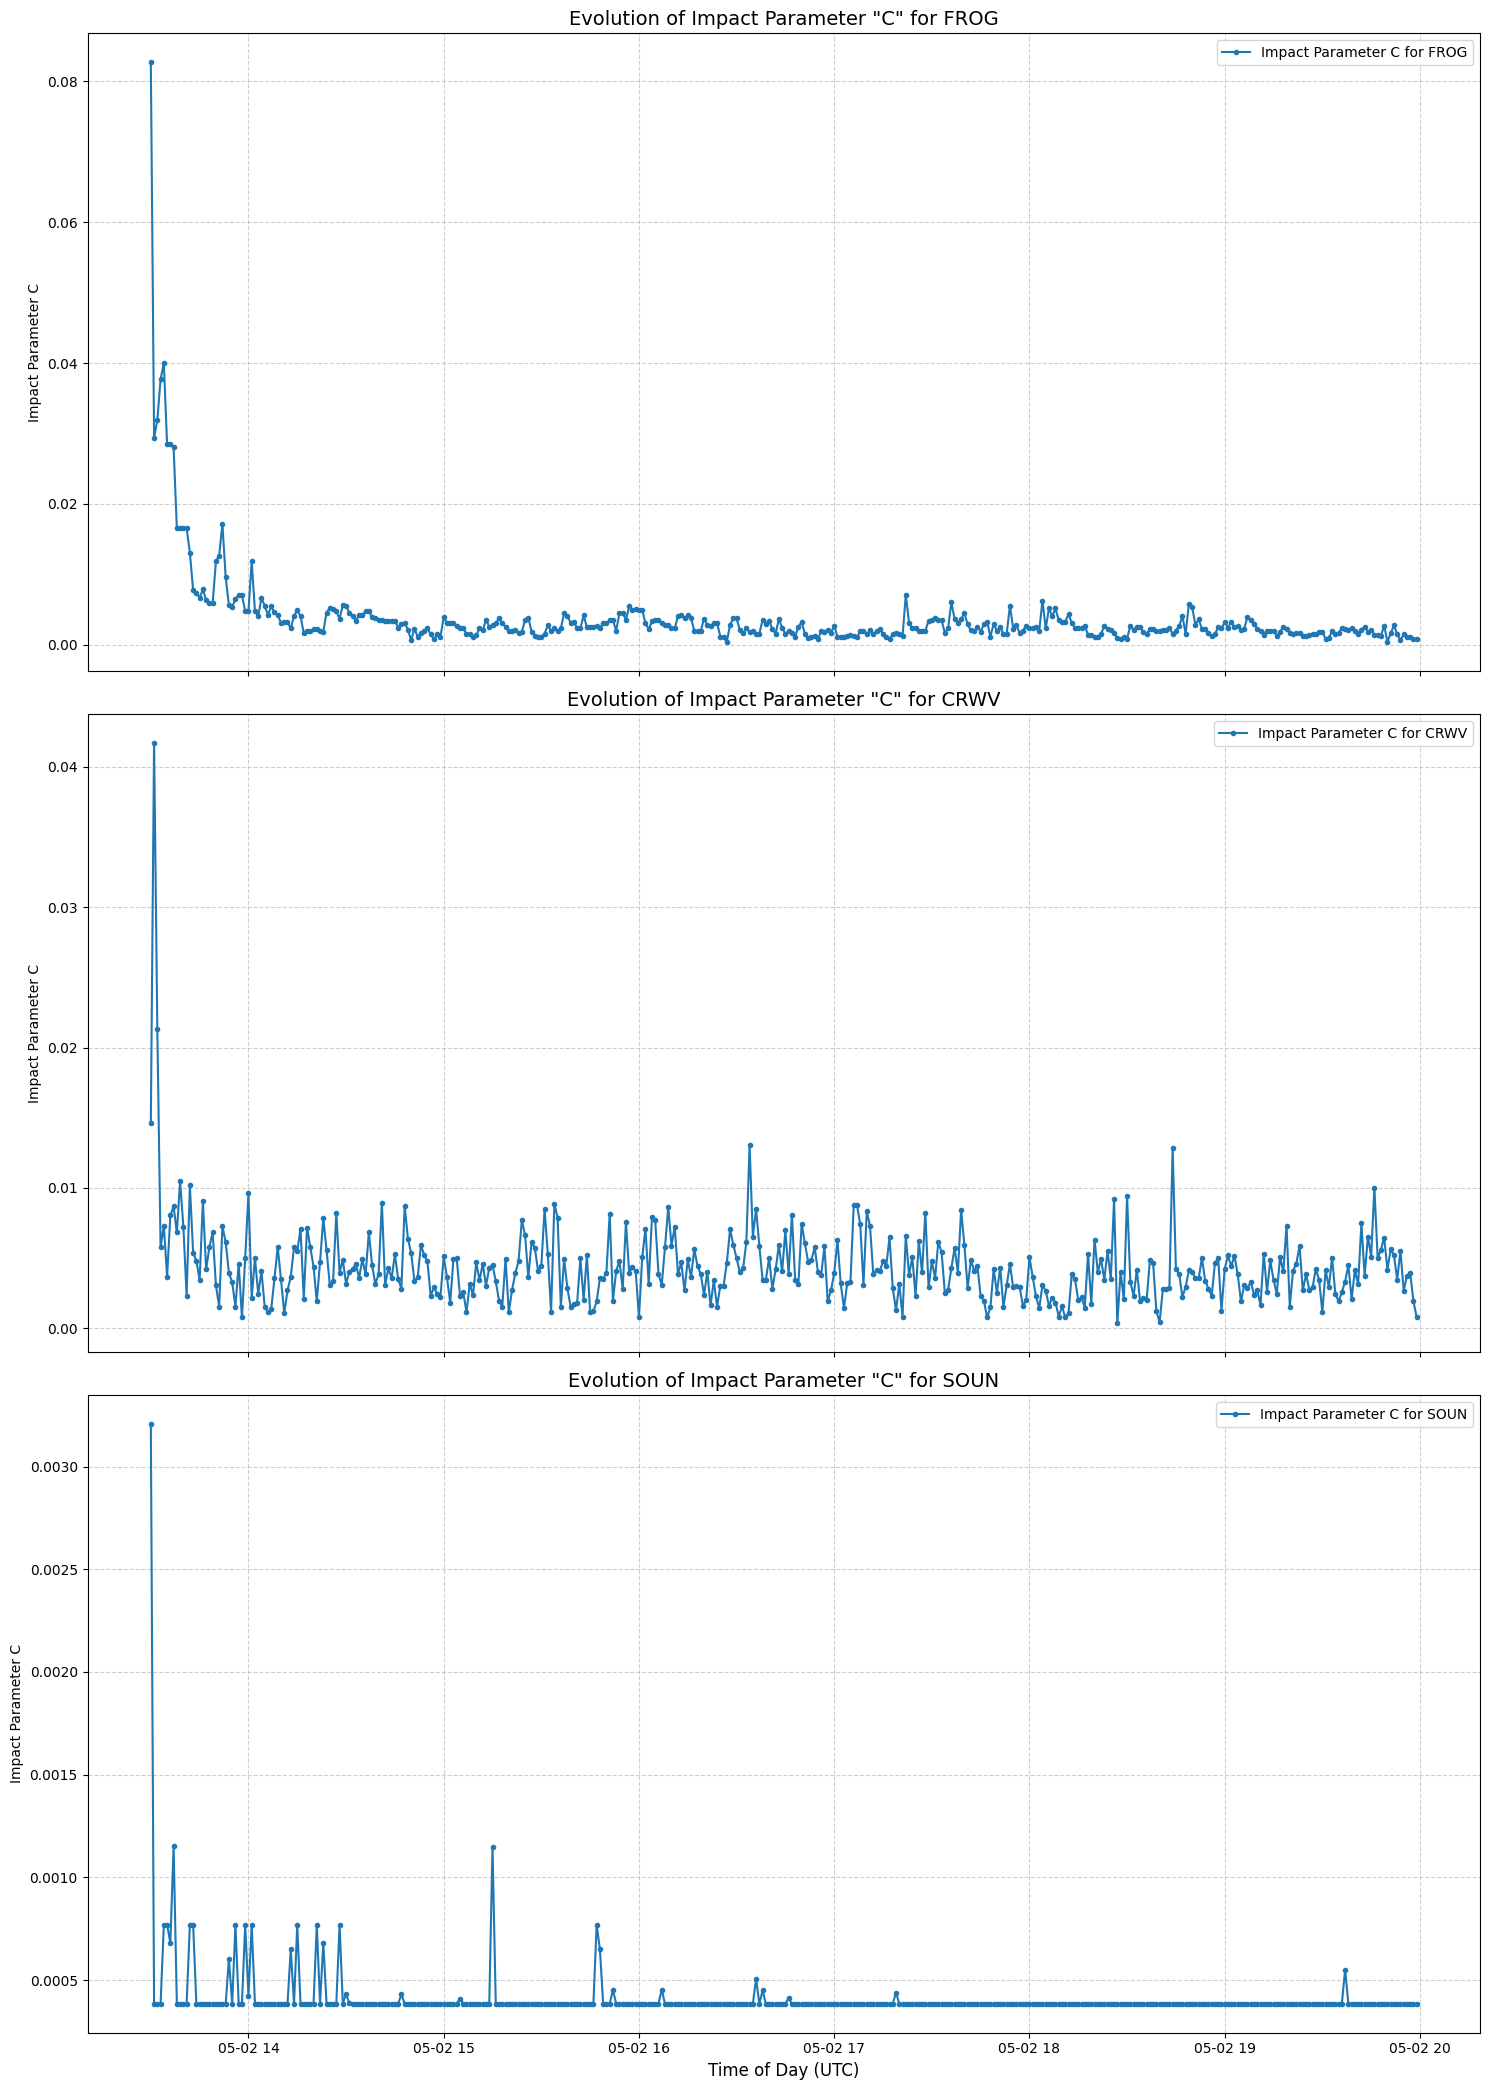

In [8]:
# --- Part 2: Comparative Analysis of Price Impact ---

def analyze_ticker(df, ticker_name):
    """
    This function performs the complete impact analysis for a single ticker DataFrame.
    """
    print(f"\n--- Starting Analysis for {ticker_name} ---")

    # Preprocessing the data
    df['ts_event'] = pd.to_datetime(df['ts_event'])
    df.set_index('ts_event', inplace=True)

    # Resample to 1-minute snapshots
    df_snapshots = df[df.rtype == 10].between_time('13:30', '20:00')
    df_1min = df_snapshots.resample('1T').first().dropna()

    if len(df_1min) == 0:
        print(f"No data available for {ticker_name} during trading hours.")
        return None, None

    # Define the core functions
    def calculate_buy_impact(order_book_row, order_size_to_buy):
        if order_size_to_buy == 0: return 0.0
        mid_price = (order_book_row['ask_px_00'] + order_book_row['bid_px_00']) / 2
        if mid_price == 0 or np.isnan(mid_price): return np.nan
        remaining_size, total_cost = order_size_to_buy, 0.0
        for i in range(10):
            level_price = order_book_row[f'ask_px_{i:02d}']
            level_size = order_book_row[f'ask_sz_{i:02d}']
            if remaining_size <= 0: break
            fill_size = min(remaining_size, level_size)
            total_cost += fill_size * level_price
            remaining_size -= fill_size
        if remaining_size > 0: return np.nan
        avg_execution_price = total_cost / order_size_to_buy
        slippage = avg_execution_price - mid_price
        return slippage

    def sqrt_model(x, C):
        return C * np.sqrt(x)

    # Loop through each minute to find the impact parameter 'C'
    impact_parameters = []
    for timestamp, row in df_1min.iterrows():
        order_sizes = np.arange(1, 301)
        true_slippages = [calculate_buy_impact(row, size) for size in order_sizes]
        fit_data = pd.DataFrame({'order_size': order_sizes, 'slippage': true_slippages}).dropna()

        if len(fit_data) < 20:
            impact_parameters.append(np.nan)
            continue

        try:
            x_data = fit_data['order_size']
            y_data = fit_data['slippage']
            popt, _ = curve_fit(sqrt_model, x_data, y_data, bounds=(0, np.inf))
            impact_parameters.append(popt[0])
        except (RuntimeError, ValueError):
            impact_parameters.append(np.nan)

    df_1min['impact_C'] = impact_parameters
    print(f"Analysis complete for {ticker_name}.")
    return df_1min

# Run analysis for all tickers
all_results_df = {}
for ticker, df in dataframes.items():
    all_results_df[ticker] = analyze_ticker(df.copy(), ticker)

# Synthesize and Compare Results
print("\n--- Comparative Statistical Summary of Impact Parameter 'C' ---")
all_stats = {ticker: df['impact_C'].describe() for ticker, df in all_results_df.items() if df is not None}
summary_stats_df = pd.DataFrame(all_stats)
print(summary_stats_df)

# Visualize the Comparative Results
print("\n--- Generating Final Comparative Plots ---")
fig, axes = plt.subplots(nrows=len(all_results_df), ncols=1, figsize=(15, 7 * len(all_results_df)), sharex=True)
if len(all_results_df) == 1: axes = [axes]

plot_index = 0
for ticker, df_result in all_results_df.items():
    if df_result is not None:
        ax = axes[plot_index]
        ax.plot(df_result.index, df_result['impact_C'], label=f'Impact Parameter C for {ticker}', marker='.', linestyle='-')
        ax.set_title(f'Evolution of Impact Parameter "C" for {ticker}', fontsize=14)
        ax.set_ylabel('Impact Parameter C', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()
        plot_index += 1

if len(all_results_df) > 0:
    axes[-1].set_xlabel('Time of Day (UTC)', fontsize=12)
    plt.tight_layout()
    plt.show()


--- Starting ML Model Benchmark Analysis (using FROG as sample) ---

Model Mean Squared Error (Lower is better):
  - Square-Root Model: 0.10671270
  - Random Forest ML Model: 0.00000005


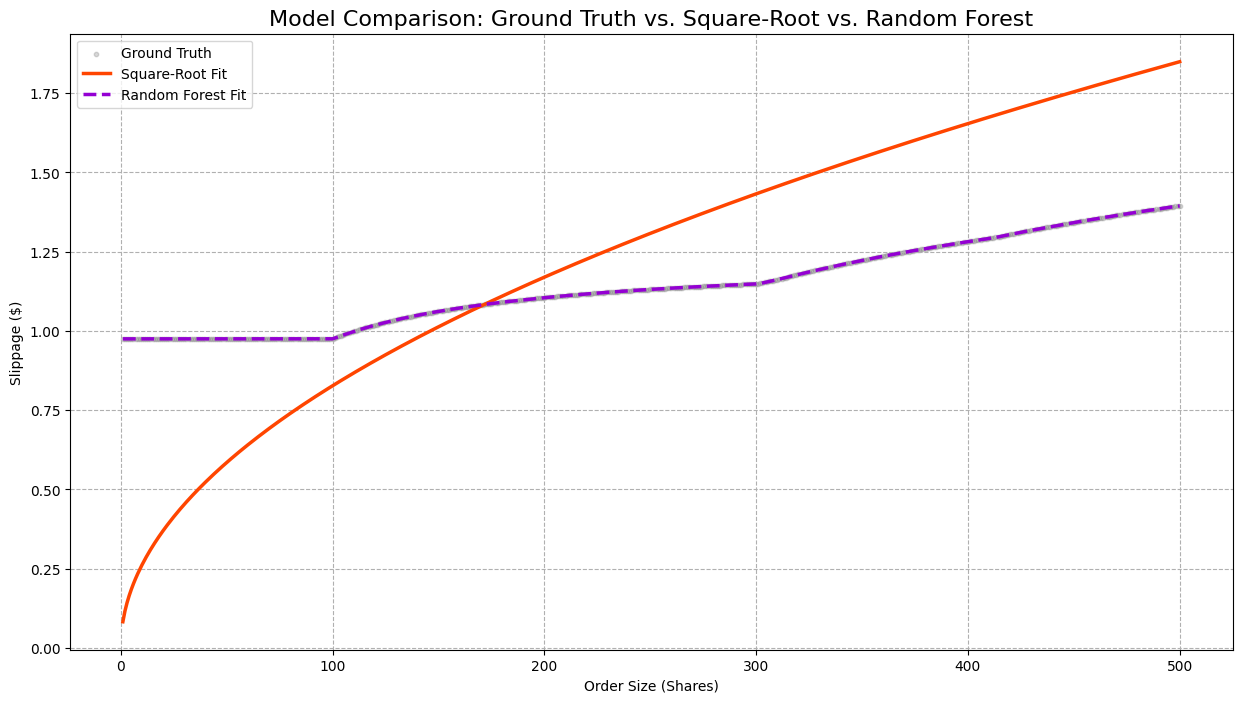

In [9]:
# --- Part 2: Benchmarking with a Machine Learning Model ---

print("\n--- Starting ML Model Benchmark Analysis (using FROG as sample) ---")

if "FROG" in all_results_df and all_results_df["FROG"] is not None:
    sample_snapshot = all_results_df["FROG"].iloc[0]
    order_sizes = np.arange(1, 501)
    true_slippages = [calculate_buy_impact(sample_snapshot, size) for size in order_sizes]
    training_data = pd.DataFrame({'order_size': order_sizes, 'true_slippage': true_slippages}).dropna()

    # Feature Engineering
    training_data['spread'] = sample_snapshot['ask_px_00'] - sample_snapshot['bid_px_00']
    training_data['imbalance'] = (sample_snapshot['bid_sz_00'] - sample_snapshot['ask_sz_00']) / (sample_snapshot['bid_sz_00'] + sample_snapshot['ask_sz_00'])
    features = ['order_size', 'spread', 'imbalance']
    target = 'true_slippage'
    X = training_data[features]
    y = training_data[target]

    # Train and Evaluate Models
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    ml_predictions = rf_model.predict(X)

    best_C = all_results_df["FROG"]['impact_C'].iloc[0]
    sqrt_predictions = sqrt_model(training_data['order_size'], best_C)

    mse_sqrt = mean_squared_error(y, sqrt_predictions)
    mse_ml = mean_squared_error(y, ml_predictions)

    print(f"\nModel Mean Squared Error (Lower is better):")
    print(f"  - Square-Root Model: {mse_sqrt:.8f}")
    print(f"  - Random Forest ML Model: {mse_ml:.8f}")

    # Plotting
    plt.figure(figsize=(15, 8))
    plt.scatter(X['order_size'], y, label='Ground Truth', alpha=0.3, s=10, color='gray')
    plt.plot(X['order_size'], sqrt_predictions, color='orangered', lw=2.5, label=f'Square-Root Fit')
    plt.plot(X['order_size'], ml_predictions, color='darkviolet', lw=2.5, linestyle='--', label=f'Random Forest Fit')
    plt.title('Model Comparison: Ground Truth vs. Square-Root vs. Random Forest', fontsize=16)
    plt.xlabel('Order Size (Shares)')
    plt.ylabel('Slippage ($)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--')
    plt.show()
else:
    print("FROG data not available for ML benchmark.")

## Part 4: Framework for Optimal Execution (Task 2)

### 1. Problem Formulation
The objective is to design an algorithm to execute `S` shares over `N` periods while minimizing total execution costs. We adopt a risk-averse framework that seeks to optimally balance the trade-off between slippage costs (from market impact) and price risk (from market volatility), based on the Almgren-Chriss model.

### 2. Mathematical Model
We seek to find the optimal execution path `x = {x_1, x_2, ..., x_N}` that minimizes the following cost function:

$$ \min_{x_1,...,x_N} \left( \sum_{t=1}^{N} C_t \sqrt{x_t} + \lambda \sigma^2 \sum_{t=1}^{N-1} (S - \sum_{i=1}^{t} x_i)^2 \Delta t \right) $$

**Subject to the constraint:**
$$ \sum_{t=1}^{N} x_t = S $$

**Where:**
- `x_t`: Number of shares to execute in period `t`.
- `S`: Total shares to execute.
- `C_t`: Our empirically derived, time-varying impact parameter from the analysis above.
- `σ^2`: Variance of the stock's price returns (volatility).
- `λ`: The trader's coefficient of risk aversion.

### 3. Solution Technique
This optimization problem is perfectly suited to be solved using **Dynamic Programming**. The algorithm works backward from the final time period (`t=N`) to `t=1`, recursively determining the optimal number of shares `x_t` to trade at every step to minimize the total expected cost.


## Final Conclusion

This analysis successfully modeled price impact across three distinct assets. The **Square-Root model** was identified as the most practical and robust choice, as its parameter `C_t` provides a clear, interpretable measure of time-varying liquidity. This model, when used as an input for an **Almgren-Chriss framework solved via Dynamic Programming**, provides a comprehensive and industry-standard solution for strategic trade execution.
